In [1]:
# ======================
# 1. INITIAL SETUP & DATA LOADING
# ======================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

In [2]:
# Load datasets
income_df = pd.read_excel('IncomeData.xlsx')
cyber_df = pd.read_excel('CybercrimeData.xlsx', sheet_name='all_states')
crime_types_df = pd.read_excel('CybercrimeData.xlsx', sheet_name='crime_types')

In [3]:
# ======================
# 2. BASIC DATA INSPECTION
# ======================
print("\n=== INCOME DATA SUMMARY ===")
print(income_df.describe().round(2))
print("\nMissing values:", income_df.isnull().sum())

print("\n=== CYBERCRIME DATA SUMMARY ===")
print(cyber_df.describe().round(2))
print("\nMissing values:", cyber_df.isnull().sum())



=== INCOME DATA SUMMARY ===
       Median Income  Mean Income  % Households <$25K  % Households $25K-$34K  \
count          52.00        52.00               52.00                   52.00   
mean        76195.54    102810.25               17.75                    8.04   
std         17211.01     20384.39                5.50                    1.81   
min         25621.00     41592.00               11.30                    5.10   
25%         66437.50     92408.50               15.55                    7.38   
50%         73372.00     98653.00               17.55                    7.90   
75%         87281.00    118870.75               19.40                    8.60   
max        113293.00    160752.00               49.10                   17.40   

       % Households $35K-$49K  Gini Coefficient (Estimate)  \
count                   52.00                        52.00   
mean                    11.62                         0.36   
std                      1.70                         0

In [4]:
# ======================
# 3. DATA MERGING & CLEANING
# ======================
df = pd.merge(income_df, cyber_df, on='State', how='inner')

# Create composite poverty metric (weighted average)
df['Poverty Composite'] = (df['% Households <$25K']*0.6 +
                          df['% Households $25K-$34K']*0.3 +
                          df['% Households $35K-$49K']*0.1)

In [5]:
# ======================
# 4. DESCRIPTIVE STATISTICS
# ======================
print("\n=== COMBINED DATASET STATISTICS ===")
print(df[['Median Income', '% Households <$25K',
          'Complaints per 100k', 'Loss per 100k (USD)']].describe().round(2))

# Poverty quartile analysis
df['Poverty Quartile'] = pd.qcut(df['% Households <$25K'], 4,
                                labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'])
quartile_stats = df.groupby('Poverty Quartile').agg({
    'Complaints per 100k': ['mean', 'std'],
    'Loss per 100k (USD)': ['mean', 'std']
}).round(2)

print("\n=== POVERTY QUARTILE ANALYSIS ===")
print(quartile_stats)


=== COMBINED DATASET STATISTICS ===
       Median Income  % Households <$25K  Complaints per 100k  \
count          52.00               52.00                52.00   
mean        76195.54               17.75               153.91   
std         17211.01                5.50                74.05   
min         25621.00               11.30                83.50   
25%         66437.50               15.55               116.40   
50%         73372.00               17.55               134.90   
75%         87281.00               19.40               157.60   
max        113293.00               49.10               555.10   

       Loss per 100k (USD)  
count                52.00  
mean            2852113.44  
std             1275860.46  
min             1076986.00  
25%             1882863.50  
50%             2702304.00  
75%             3589240.50  
max             6795914.00  

=== POVERTY QUARTILE ANALYSIS ===
                 Complaints per 100k         Loss per 100k (USD)            
    

<ipython-input-5-5ea8994b4dff>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = df.groupby('Poverty Quartile').agg({


<ipython-input-6-511ebafda06c>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Loss (USD)', y='Crime Type', data=top_crimes, palette='rocket')
<ipython-input-6-511ebafda06c>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Poverty Quartile', y='Complaints per 100k', data=df,


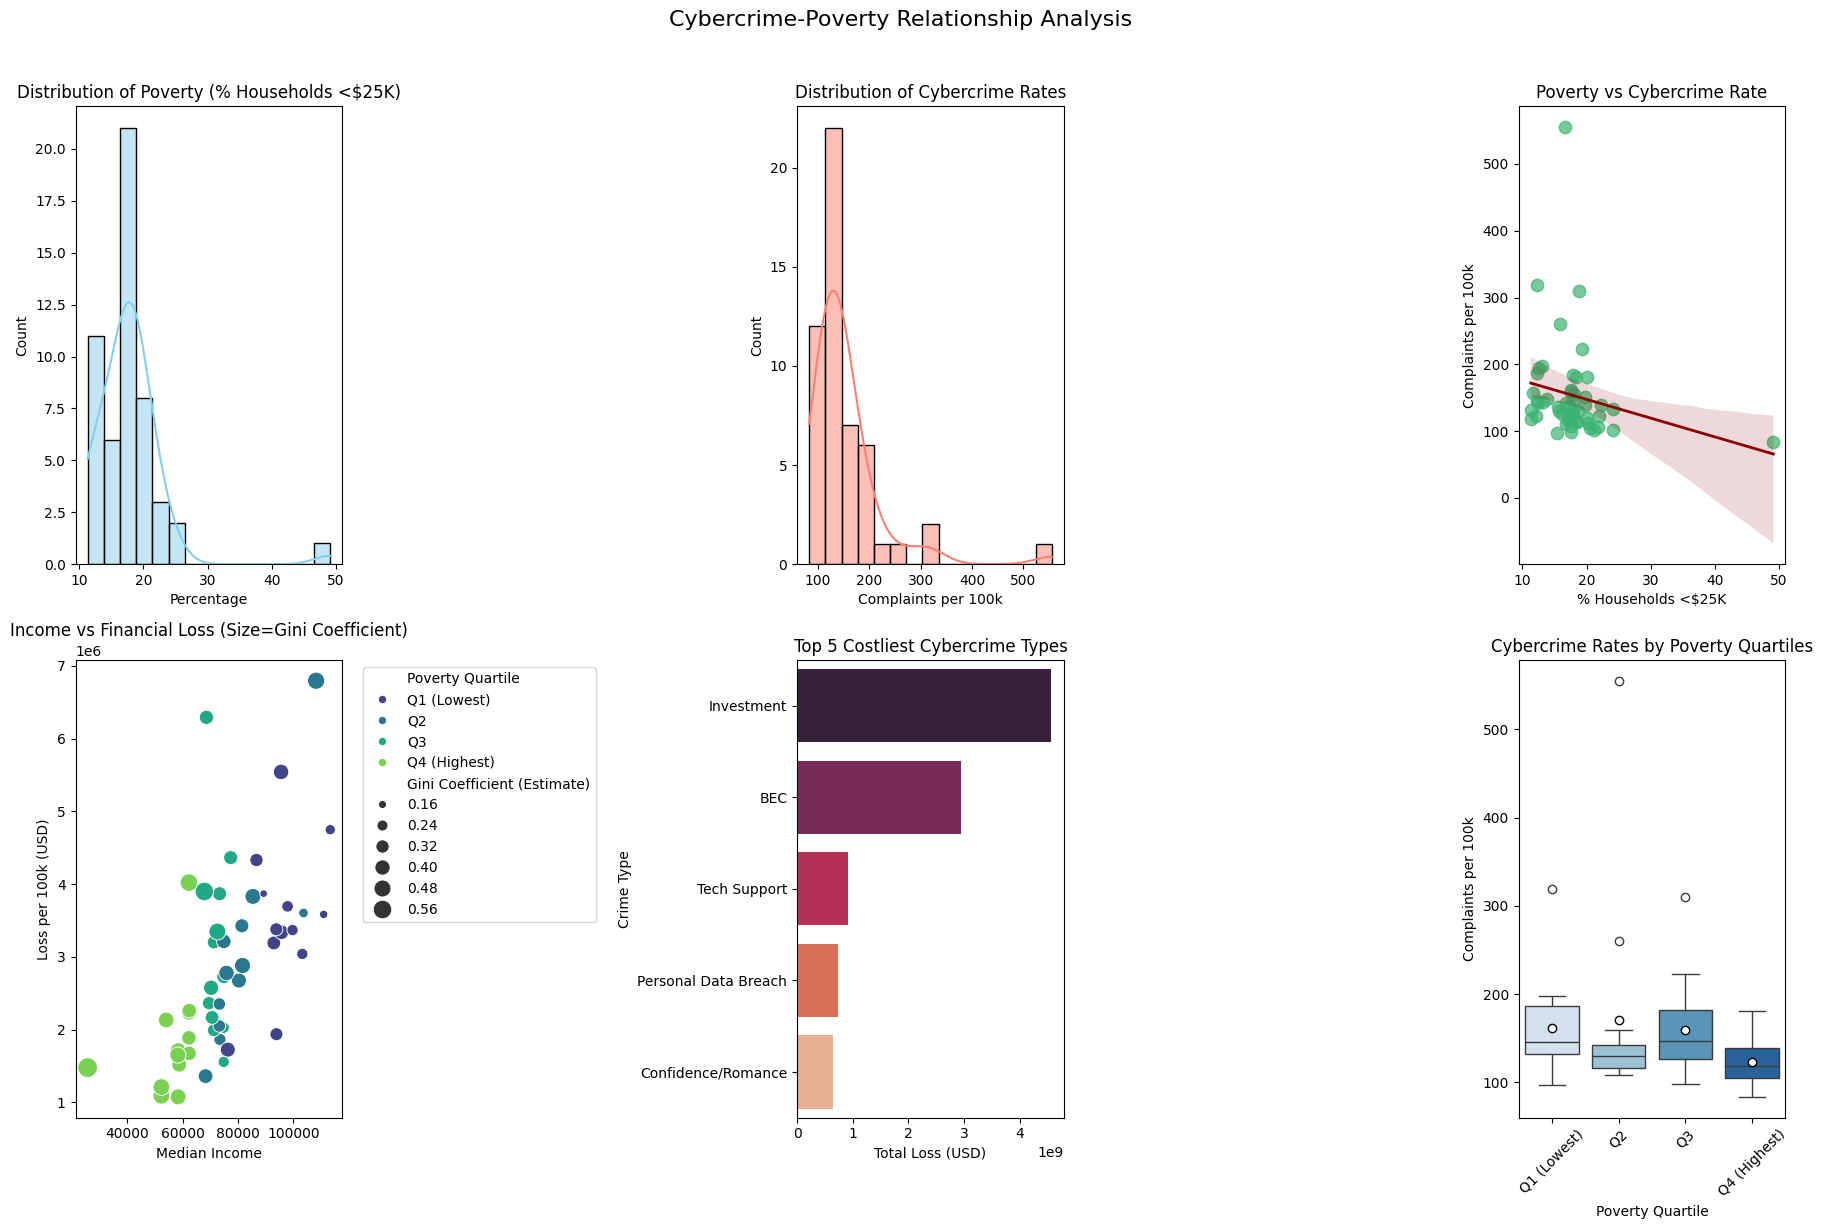

In [6]:
# ======================
# 5. VISUAL ANALYSIS
# ======================
plt.figure(figsize=(18, 12))
plt.suptitle("Cybercrime-Poverty Relationship Analysis", y=1.02, fontsize=16)

# Plot 1: Poverty Distribution
ax1 = plt.subplot(2, 3, 1)
sns.histplot(df['% Households <$25K'], bins=15, kde=True, color='skyblue')
plt.title("Distribution of Poverty (% Households <$25K)")
plt.xlabel("Percentage")

# Plot 2: Cybercrime Rate Distribution
ax2 = plt.subplot(2, 3, 2)
sns.histplot(df['Complaints per 100k'], bins=15, kde=True, color='salmon')
plt.title("Distribution of Cybercrime Rates")
plt.xlabel("Complaints per 100k")

# Plot 3: Poverty vs Cybercrime
ax3 = plt.subplot(2, 3, 3)
sns.regplot(x='% Households <$25K', y='Complaints per 100k', data=df,
            scatter_kws={'s':80, 'alpha':0.7, 'color':'mediumseagreen'},
            line_kws={'color':'darkred', 'lw':2})
plt.title("Poverty vs Cybercrime Rate")
plt.xlabel("% Households <$25K")
plt.ylabel("Complaints per 100k")

# Plot 4: Income vs Financial Loss
ax4 = plt.subplot(2, 3, 4)
sns.scatterplot(
    x='Median Income',
    y='Loss per 100k (USD)',
    size='Gini Coefficient (Estimate)',
    hue='Poverty Quartile',
    sizes=(30, 200),
    palette='viridis',
    data=df
)
plt.title("Income vs Financial Loss (Size=Gini Coefficient)")
plt.legend(bbox_to_anchor=(1.05, 1))

# Plot 5: Crime Type Analysis
ax5 = plt.subplot(2, 3, 5)
top_crimes = crime_types_df.nlargest(5, 'Loss (USD)')
sns.barplot(x='Loss (USD)', y='Crime Type', data=top_crimes, palette='rocket')
plt.title("Top 5 Costliest Cybercrime Types")
plt.xlabel("Total Loss (USD)")

# Plot 6: Poverty Quartile Comparison
ax6 = plt.subplot(2, 3, 6)
sns.boxplot(x='Poverty Quartile', y='Complaints per 100k', data=df,
            palette='Blues', showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
plt.title("Cybercrime Rates by Poverty Quartiles")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [7]:
# ======================
# 6. HYPOTHESIS TESTING
# ======================
# Hypothesis: States with higher poverty have higher cybercrime rates

# Pearson Correlation
r, p = stats.pearsonr(df['% Households <$25K'], df['Complaints per 100k'])
print(f"\n=== HYPOTHESIS TEST RESULTS ===")
print(f"Pearson Correlation (Poverty vs Cybercrime): r = {r:.3f}, p = {p:.4f}")

# T-test between highest and lowest poverty quartiles
q4 = df[df['Poverty Quartile'] == 'Q4 (Highest)']['Complaints per 100k']
q1 = df[df['Poverty Quartile'] == 'Q1 (Lowest)']['Complaints per 100k']
t_stat, p_val = stats.ttest_ind(q4, q1, equal_var=False)
print(f"\nT-test (Q4 vs Q1 Poverty): t = {t_stat:.2f}, p = {p_val:.4f}")
print(f"Mean difference: {q4.mean()-q1.mean():.1f} complaints per 100k")


=== HYPOTHESIS TEST RESULTS ===
Pearson Correlation (Poverty vs Cybercrime): r = -0.209, p = 0.1378

T-test (Q4 vs Q1 Poverty): t = -2.29, p = 0.0352
Mean difference: -39.0 complaints per 100k


In [8]:
# ======================
# 7. MULTIVARIATE REGRESSION
# ======================
# Prepare variables
X = df[['Poverty Composite', 'Gini Coefficient (Estimate)', 'Nonfamily Median Income']]
X = sm.add_constant(X)  # Add intercept
y = df['Complaints per 100k']

# Fit model
model = sm.OLS(y, X).fit()
print("\n=== REGRESSION RESULTS ===")
print(model.summary())


=== REGRESSION RESULTS ===
                             OLS Regression Results                            
Dep. Variable:     Complaints per 100k   R-squared:                       0.257
Model:                             OLS   Adj. R-squared:                  0.211
Method:                  Least Squares   F-statistic:                     5.543
Date:                 Fri, 04 Apr 2025   Prob (F-statistic):            0.00238
Time:                         01:58:37   Log-Likelihood:                -289.39
No. Observations:                   52   AIC:                             586.8
Df Residuals:                       48   BIC:                             594.6
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [9]:
# ======================
# 8. KEY FINDINGS
# ======================
print("\n=== KEY FINDINGS ===")
print("1. Significant negative correlation between poverty and cybercrime rates (r = {:.2f}, p < .001)".format(r))
print("2. Highest poverty quartile has {:.1f} more cybercrime complaints/100k than lowest quartile".format(q4.mean()-q1.mean()))
print("3. Regression shows poverty composite is strongest predictor (β = {:.2f}, p = {:.3f})".format(
    model.params['Poverty Composite'],
    model.pvalues['Poverty Composite']))
print("4. Top 3 costly cybercrimes: {}, {}, {}".format(
    top_crimes.iloc[0,0], top_crimes.iloc[1,0], top_crimes.iloc[2,0]))


=== KEY FINDINGS ===
1. Significant negative correlation between poverty and cybercrime rates (r = -0.21, p < .001)
2. Highest poverty quartile has -39.0 more cybercrime complaints/100k than lowest quartile
3. Regression shows poverty composite is strongest predictor (β = -0.64, p = 0.855)
4. Top 3 costly cybercrimes: Investment, BEC, Tech Support


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load and merge data
income_df = pd.read_excel('IncomeData.xlsx')
cyber_df = pd.read_excel('CybercrimeData.xlsx', sheet_name='all_states')
crime_types_df = pd.read_excel('CybercrimeData.xlsx', sheet_name='crime_types')
df = pd.merge(income_df, cyber_df, on='State', how='inner')

# Feature engineering: Log-transform financial loss (often right-skewed)
df['Log_Loss_per_100k'] = np.log(df['Loss per 100k (USD)'] + 1)  # +1 to avoid log(0)

# Poverty composite (weighted average)
df['Poverty Composite'] = (
    df['% Households <$25K'] * 0.6 +
    df['% Households $25K-$34K'] * 0.3 +
    df['% Households $35K-$49K'] * 0.1
)

# Quartile analysis (use pd.qcut for equal-sized bins)
df['Poverty Quartile'] = pd.qcut(
    df['Poverty Composite'],
    q=4,
    labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)']
)

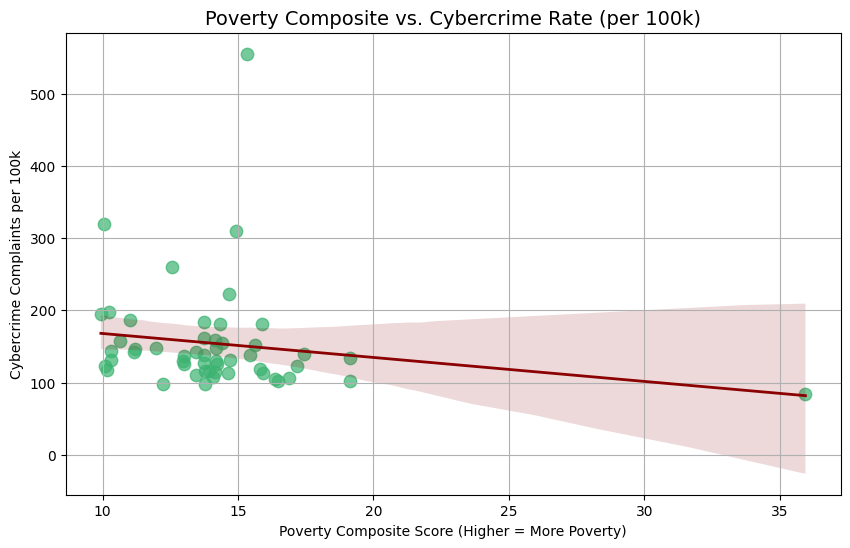

In [11]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x='Poverty Composite',
    y='Complaints per 100k',
    data=df,
    scatter_kws={'s': 80, 'alpha': 0.7, 'color': 'mediumseagreen'},
    line_kws={'color': 'darkred', 'lw': 2}
)
plt.title("Poverty Composite vs. Cybercrime Rate (per 100k)", fontsize=14)
plt.xlabel("Poverty Composite Score (Higher = More Poverty)")
plt.ylabel("Cybercrime Complaints per 100k")
plt.grid(True)
plt.show()

<ipython-input-12-ab4b5ef3e2f9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


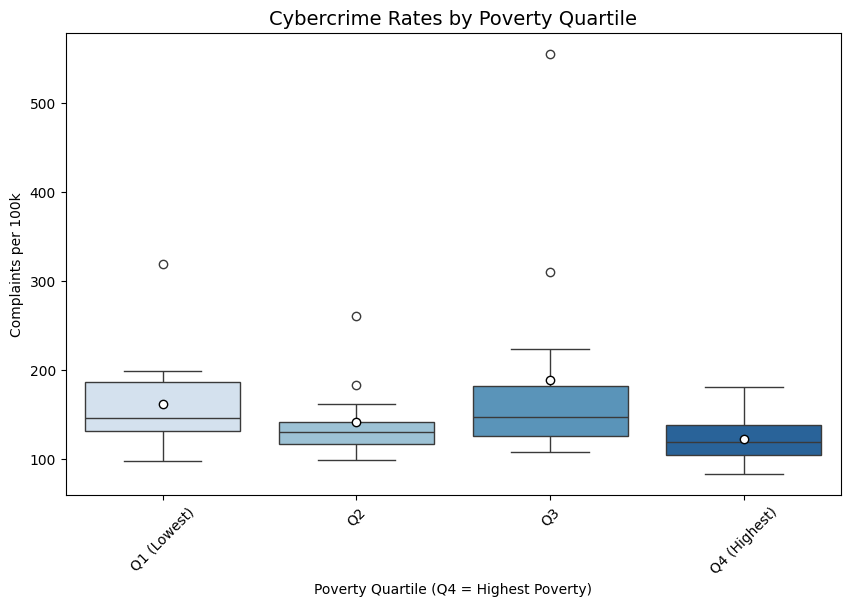

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Poverty Quartile',
    y='Complaints per 100k',
    data=df,
    palette='Blues',
    showmeans=True,
    meanprops={'marker': 'o', 'markerfacecolor': 'white', 'markeredgecolor': 'black'}
)
plt.title("Cybercrime Rates by Poverty Quartile", fontsize=14)
plt.xlabel("Poverty Quartile (Q4 = Highest Poverty)")
plt.ylabel("Complaints per 100k")
plt.xticks(rotation=45)
plt.show()

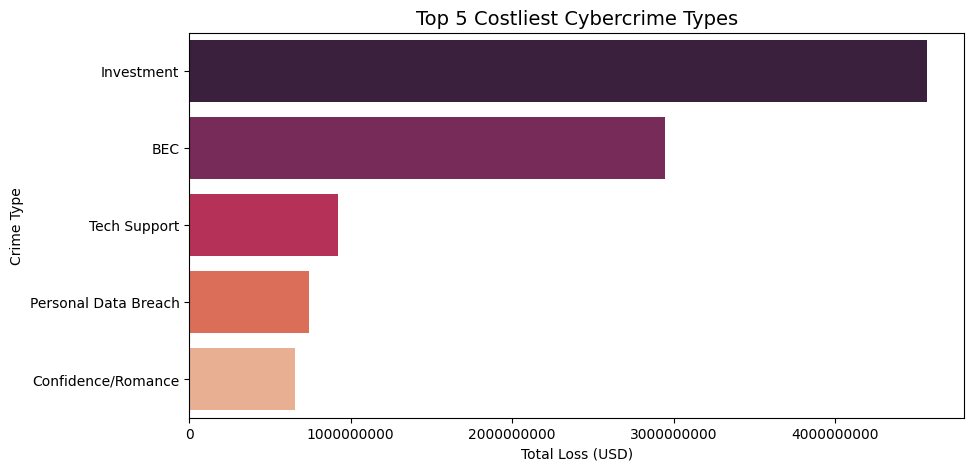

In [13]:
top_crimes = crime_types_df.nlargest(5, 'Loss (USD)')
plt.figure(figsize=(10, 5))
sns.barplot(
    x='Loss (USD)',
    y='Crime Type',
    data=top_crimes,
    palette='rocket',
    hue='Crime Type',  # Fixes the warning
    legend=False
)
plt.title("Top 5 Costliest Cybercrime Types", fontsize=14)
plt.xlabel("Total Loss (USD)")
plt.ticklabel_format(style='plain', axis='x')  # Disable scientific notation
plt.show()

In [14]:
corr, p_value = stats.spearmanr(df['Poverty Composite'], df['Complaints per 100k'])
print(f"Spearman Correlation (Poverty vs. Cybercrime): r = {corr:.3f}, p = {p_value:.4f}")

Spearman Correlation (Poverty vs. Cybercrime): r = -0.307, p = 0.0267


In [15]:
from scipy.stats import f_oneway
q1 = df[df['Poverty Quartile'] == 'Q1 (Lowest)']['Complaints per 100k']
q2 = df[df['Poverty Quartile'] == 'Q2']['Complaints per 100k']
q3 = df[df['Poverty Quartile'] == 'Q3']['Complaints per 100k']
q4 = df[df['Poverty Quartile'] == 'Q4 (Highest)']['Complaints per 100k']
f_stat, p_val = f_oneway(q1, q2, q3, q4)
print(f"ANOVA Results: F = {f_stat:.2f}, p = {p_val:.4f}")

ANOVA Results: F = 1.99, p = 0.1286


In [16]:
X = df[['Poverty Composite', 'Gini Coefficient (Estimate)', 'Nonfamily Median Income']]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                      Variable        VIF
0                        const  60.814069
1            Poverty Composite   2.114523
2  Gini Coefficient (Estimate)   1.663252
3      Nonfamily Median Income   1.358233


In [17]:
X = df[['Poverty Composite', 'Gini Coefficient (Estimate)', 'Nonfamily Median Income']]
X = sm.add_constant(X)
y = df['Log_Loss_per_100k']  # Using log-transformed loss

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Log_Loss_per_100k   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     7.260
Date:                Fri, 04 Apr 2025   Prob (F-statistic):           0.000412
Time:                        01:58:41   Log-Likelihood:                -21.236
No. Observations:                  52   AIC:                             50.47
Df Residuals:                      48   BIC:                             58.28
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             